In [1]:
from sklearn.datasets import load_wine
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
plt.style.use('seaborn')

In [3]:
df = load_wine(as_frame=True)['data']
df['target'] = load_wine(as_frame=True)['target']
df.corr(method='pearson')
# Есть довольно высокие корреляции, но не буду пока обращать внимание на этот факт
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


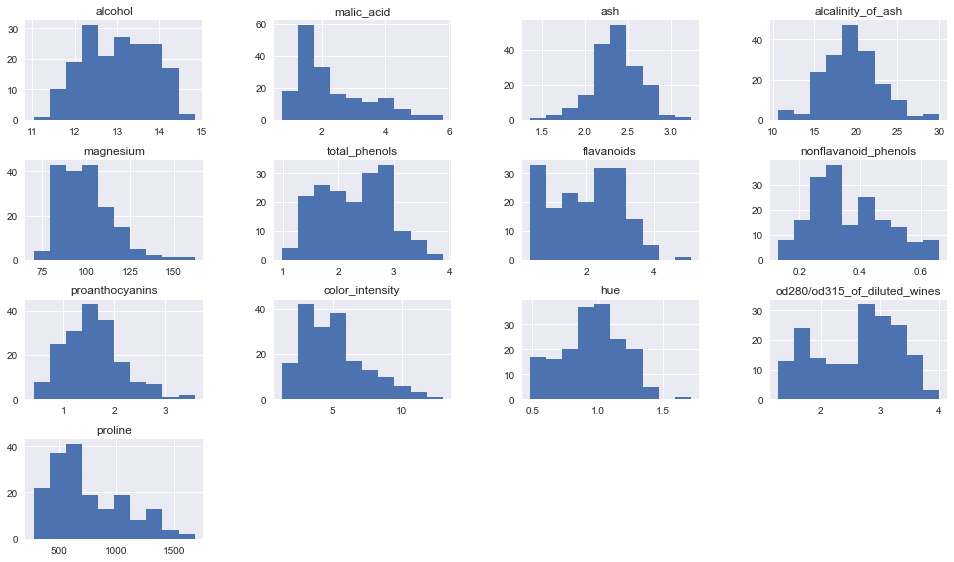

In [4]:
# Поостроим гистрограммы фичей (некоторые похожи на нормальное распределения, некоторые даже не уномодальные)
fig = plt.figure(figsize = (16, 9))
for i, feature in enumerate(df.columns[:-1]):
    ax = fig.add_subplot(4,4,i+1)
    ax.hist(df[feature])
    ax.set_title(feature)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

$P(y_i=C_k|x_i)=\frac{P(x_i|y_i=C_k)\cdot P(y_i=C_k)}{P(x_i)}$

In [39]:
# Нормальной распределение
class Gaussian:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
    
    def evalf(self, x):
        return 1 / np.sqrt(2*np.pi*self.var) * np.exp(-1/2*(x-self.mean)**2/self.var)
    
    def plot(self, lb, rb, num):
        X = np.linspace(lb, rb, num)
        return plt.plot(X, self.pdf(X))

In [112]:
class NaiveBayes:
    def __init__(self, data, X, Y):
        self.data = data.reset_index(drop = True)
        self.X = X.reset_index(drop = True)
        self.Y = Y
        
    def calc_prior(self, label):
        return self.data[self.data[self.Y] == label].shape[0] / self.data.shape[0]
    
    def get_normal_distributions(self):
        distrs = {}
        for col in self.X.columns:
            for label in self.data[self.Y].unique():
                filtered_data = self.data[self.data[self.Y] == label][col]
                mean, var = filtered_data.mean(), filtered_data.var()
                distrs[f'{col}_{label}'] = Gaussian(mean, var)
        return distrs
    
    
    def predict(self):
        predicted = []
        distrs = self.get_normal_distributions()
        for i in range(self.X.shape[0]):
            opt_label, max_prob = None, 0
            for label in self.data[self.Y].unique():
                prob_x_y = self.calc_prior(label)
                for col in self.X.columns:
                    prob_x_y *= distrs[f'{col}_{label}'].evalf(self.X[col][i])
                if prob_x_y > max_prob:
                    max_prob, opt_label = prob_x_y, label
            predicted.append(opt_label)
        return predicted

In [126]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
x_test = test[test.columns[:-1]]
y_test = test[test.columns[-1]].to_list()
y_pred = NaiveBayes(train, x_test, 'target').predict()

from sklearn.metrics import f1_score, confusion_matrix
print(f1_score(y_test, y_pred, average = 'micro'))
confusion_matrix(y_pred, y_test)

1.0


array([[11,  0,  0],
       [ 0, 16,  0],
       [ 0,  0,  9]])

Kernel Density Estimation

In [104]:
import sympy as syms

x = syms.Symbol('x')

class KDE:
    def __init__(self, kernel='Gaussian'):
        self.kernel = kernel
        
    def synbolic_fit(self, X, bandwidth=0.1):
        func_exp = 0
        for xi in X:
            func_exp += 1/syms.sqrt(2*syms.pi)*syms.exp(-((x - xi)/bandwidth)**2/2)
        return func_exp / (bandwidth * len(X))
    
    def func_fit_eval(self, X, value_x, bandwidth=0.1):
        func_val = 0 
        for xi in X:
            func_val += 1/np.sqrt(2*np.pi)*np.exp(-((value_x - xi)/bandwidth)**2/2)
        return func_val / (len(X)*bandwidth)

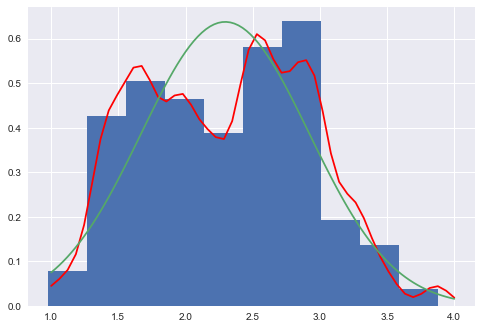

In [15]:
# Построим KDE и сравним с гистограммой
a = KDE('Gaussian')
exp = a.fit(df['total_phenols'])
X = np.linspace(1, 4)
values = [exp.subs('x', x).evalf() for x in X]
# Построим графики для сравнения KDE и просто зафиченного нормального распределения 
mean, var = df['total_phenols'].mean(), df['total_phenols'].var()
plt.hist(df['total_phenols'], density = True)
plt.plot(X, values, 'r')
Gaussian(mean, var).plot(1, 4, 100)

In [127]:
# Попробуем построить ту же модель только с приближенными распределениями